# Dogs vs Cats

In [1]:
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [2]:
TRAINING_DIR = '../data/train'
TEST_DIR = '../data/test'
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # RGB color

### Training data

In [3]:
filenames = os.listdir(TRAINING_DIR)
categories = [ 1 if filename.split('.')[0] == 'dog' else 0 for filename in filenames ]

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head(2)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0


In [5]:
df.tail(2)

,filename,category
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


In [6]:
df['category'].value_counts(dropna=False)

1    12500
0    12500
Name: category, dtype: int64

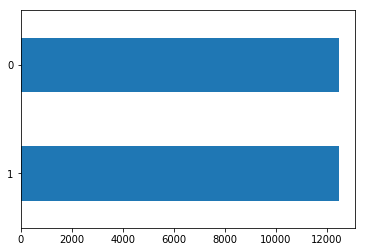

In [7]:
df['category'].value_counts(dropna=False).plot.barh()

### View sample image

In [8]:
sample = random.choice(filenames)

In [9]:
sample

'dog.11819.jpg'

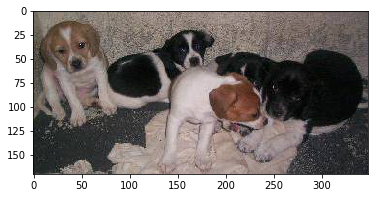

In [10]:
image = load_img(os.path.join(TRAINING_DIR, sample))
plt.imshow(image)

### Build model

In [11]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

### Callbacks

**Early Stop** To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [13]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction** We will reduce the learning rate when then accuracy not increase for 2 steps

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare Test and Train Data

In [16]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

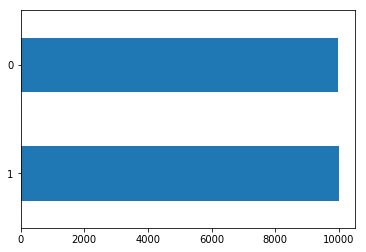

In [17]:
train_df['category'].value_counts().plot.barh()

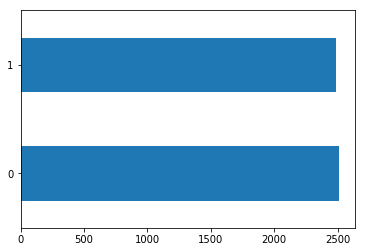

In [18]:
validate_df['category'].value_counts().plot.barh()

In [19]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

### Traning Generator

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_df['category'] = df['category'].apply(str) # From image generator to work with binary class_mode
validate_df['category'] = validate_df['category'].apply(str)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    TRAINING_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size,
)

Found 20000 images belonging to 2 classes.


### Validation Generator

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    TRAINING_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size,
)

Found 5000 images belonging to 2 classes.


### See how our generator work

Found 1 images belonging to 1 classes.


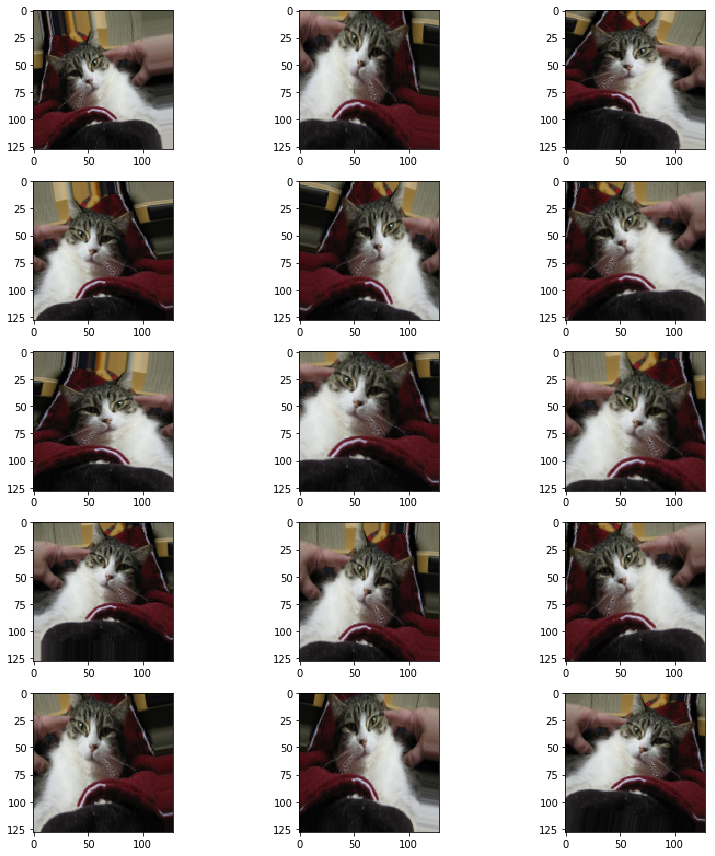

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    TRAINING_DIR, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [23]:
model_json = model.to_json()
with open("../models/model.json", "w") as json_file:
    json_file.write(model_json)

### Fit Model

In [24]:
epochs = 10 # if FAST_RUN else 50

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1333/1333 [==============================] - 19815s 15s/step - loss: 0.7798 - acc: 0.5664 - val_loss: 0.7411 - val_acc: 0.5075
Epoch 2/10
1333/1333 [==============================] - 2401s 2s/step - loss: 0.6881 - acc: 0.5961 - val_loss: 0.7378 - val_acc: 0.4897
Epoch 3/10
1333/1333 [==============================] - 2485s 2s/step - loss: 0.6827 - acc: 0.5981 - val_loss: 0.7343 - val_acc: 0.5035

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
1333/1333 [==============================] - 2392s 2s/step - loss: 0.6749 - acc: 0.6131 - val_loss: 0.7247 - val_acc: 0.5021
Epoch 5/10
1333/1333 [==============================] - 2749s 2s/step - loss: 0.6719 - acc: 0.6159 - val_loss: 0.7377 - val_acc: 0.4923

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/10
1333/1333 [==============================] - 2194s 2s/step - loss: 0.6683 - acc: 0.6183 - val_los

In [25]:
model.save_weights("../models/model.h5")

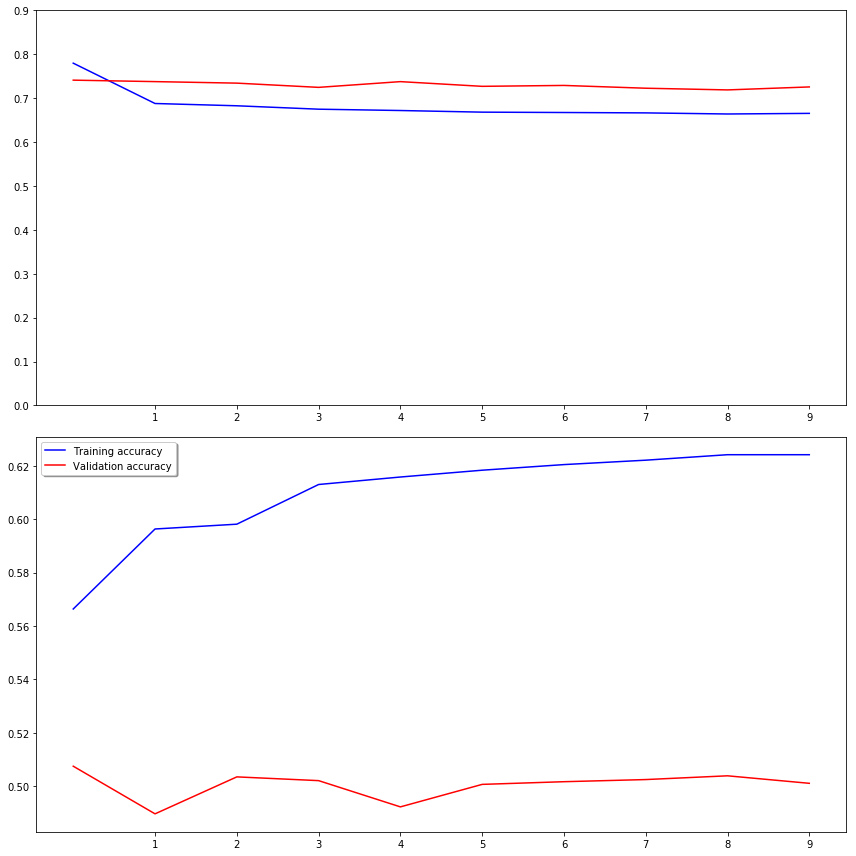

In [27]:
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()